In [105]:
from data_processing import *
from train_trace_2 import *
from visualization import plot_segment


In [191]:
tab = pd.read_csv(".\data\set1_tab.csv", encoding="utf-16")
imu = pd.read_csv(".\data\set1_imu.csv", encoding="utf-8")

In [205]:
def merge_data_based_on_tab(tab, imu, smoothness, step):
    t_left, t_right = tab["host_timestamp"].iloc[[0, -1]]
    i_left, i_right = imu["host_timestamp"].iloc[[0, -1]]
    left = max(t_left, i_left) #later start
    right = min(t_right, i_right) #earlier ending

    # use tab data set as base to merge on
    df = tab[(tab["host_timestamp"] >= left) & (tab["host_timestamp"] <= right)].copy() 

    is_entering_range = df["in_range"].diff() == 1
    is_reset_in_range = (df["in_range"] == 1) & (df["reset"] == 1)
    is_start_of_segment = is_entering_range | is_reset_in_range
    
    # Number segments
    df["segment"] = is_start_of_segment.cumsum()
    
    # Ignore parts that are out-of-range
    df = df[df["in_range"] == 1]

    dfs = dict()
    ## add segemnt column

    segment = 0

    for _, df in df.groupby("segment"):

        data = pd.DataFrame()

        mask = df["touch"] > 0.0
        if not mask.any():
            continue
        start, end = df.index[mask][[0, -1]] # mask hat für die gesamte colum true/false werte und start/end sind erste letzte true werte
        df = df.loc[start:end]

        imu_start = imu.loc[(imu['host_timestamp']-df["host_timestamp"].loc[start]).abs().argsort()[:1]].index[0]
        imu_end = imu.loc[(imu['host_timestamp']-df["host_timestamp"].loc[end]).abs().argsort()[:1]].index[0]


        imu_df = imu.iloc[imu_start:imu_end]

        # Compute distance
        x = df["x"].values
        y = df["y"].values
        dx = np.diff(x, prepend=x[0])
        dy = np.diff(y, prepend=y[0])
        d = np.sqrt(dx ** 2 + dy ** 2)
        t = np.cumsum(d)
        length = t[-1]

        # Fit cubic splines
        mask = d > 1e-5
        if mask.sum() <= 3:
            continue
        tck, _ = scipy.interpolate.splprep([x[mask], y[mask]], u=t[mask], s=smoothness)

        # Sample spline at regular (spatial) interval
        data["t_r"] = np.arange(0, length, step)
        x_r, y_r = scipy.interpolate.splev(data["t_r"], tck, der=0)

        data["x_r"] = x_r
        data["y_r"] = y_r

        t_imu = imu_df["host_timestamp"] - np.min(imu_df["host_timestamp"])
        imu_time_span = np.linspace(0, np.max(t_imu), len(data))

        for column in ['ax', 'ay', 'az', 'gx', 'gy', 'gz']:
            data[column] = np.interp(imu_time_span, t_imu, imu_df[column])

        # Use small dtypes => WHY???
        # x_r = x_r.astype(np.float32)
        # y_r = y_r.astype(np.float32)

        # Collect sample
        # sample = x_r, y_r, t_r
        # samples.append(sample)
        # zusammenfügen
        dfs[segment] = data
        segment = segment + 1
    print(dfs.keys())

    df = pd.concat([df.assign(segment=k) for k,df in dfs.items()])

    return df

In [206]:
smoothness = 200.0
step = 0.5
d = merge_data_based_on_tab(tab, imu, smoothness, step)
d.head()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52])


,t_r,x_r,y_r,ax,ay,az,gx,gy,gz,segment
0,0.0,171.081563,175.444042,-8.331800,3.205200,3.801000,0.050100,-0.108700,-0.474000,0
1,0.5,170.148674,174.619624,-8.499349,2.549868,3.498808,-0.078887,-0.083064,-0.423374,0
2,1.0,169.290593,173.889512,-8.647959,2.049213,3.270164,-0.171738,-0.064760,-0.356602,0
3,1.5,168.504520,173.249715,-8.683283,2.473794,3.481462,-0.048428,-0.090313,-0.193244,0
4,2.0,167.787657,172.696245,-8.713944,2.900544,3.627069,0.047904,-0.103357,-0.065693,0


In [208]:
len(d)

205823

In [187]:
tab.head()

,host_timestamp,x,y,z,in_range,touch,pressure,reset
0,43375067069000,-125.0,727.0,0,0,0,0,0
1,43375085835600,-125.0,727.0,0,0,0,0,0
2,43375103211700,-125.0,727.0,0,0,0,0,0
3,43375119624300,-125.0,727.0,0,0,0,0,0
4,43375136587100,-125.0,727.0,0,0,0,0,0


In [155]:
# adjust host_timestamps so I do not have to deal with gigantic values in the end when I interpolate

t_left, t_right = tab["host_timestamp"].iloc[[0, -1]]
i_left, i_right = imu["host_timestamp"].iloc[[0, -1]]
left = max(t_left, i_left) #later start
right = min(t_right, i_right) #earlier ending

# use tab data set as base to merge on
df = tab[(tab["host_timestamp"] >= left) & (tab["host_timestamp"] <= right)].copy() 

is_entering_range = df["in_range"].diff() == 1
is_reset_in_range = (df["in_range"] == 1) & (df["reset"] == 1)
is_start_of_segment = is_entering_range | is_reset_in_range

# Number segments
df["segment"] = is_start_of_segment.cumsum()


In [156]:
mask = df["touch"] > 0.0
start, end = df.index[mask][[0, -1]]
df = df.loc[start:end]

In [157]:
imu_start = imu.loc[(imu['host_timestamp']-df["host_timestamp"].loc[start]).abs().argsort()[:1],"host_timestamp"]
imu_end = imu.loc[(imu['host_timestamp']-df["host_timestamp"].loc[end]).abs().argsort()[:1],"host_timestamp"]

In [158]:
x = df["x"].values
y = df["y"].values
dx = np.diff(x, prepend=x[0])
dy = np.diff(y, prepend=y[0])
d = np.sqrt(dx ** 2 + dy ** 2)
t = np.cumsum(d)
length = t[-1] # 133016.66149494878, aufusmmierte distanzen nicht länge

In [160]:
# Fit cubic splines
smoothness = 200.0
step = 0.5
mask = d > 1e-5
tck, _ = scipy.interpolate.splprep([x[mask], y[mask]], u=t[mask], s=smoothness)
# tck is list, first elem is dimension (25319,), tck is length 3, 
# second elem apperas to be list len 1 of list len 2 including an array shape (25315,) and (25315,)
#  as well as third which is a list [3]

data = pd.DataFrame()

# Sample spline at regular (spatial) interval
data["t_r"] = np.arange(0, length, step) # shape (266034,)
# ich will hier statt index werten die host_timestamp werte
# create here a second timeline that has the first host timestemp of imu and last and than
# make same number of steps as t_r has and interpolate?
x_r, y_r = scipy.interpolate.splev(data["t_r"], tck, der=0)
data["x_r"] = x_r
data["y_r"] = y_r

In [166]:
data.head()

,t_r,x_r,y_r
0,0.0,169.587935,173.947153
1,0.5,167.901378,173.510224
2,1.0,168.185105,173.696108
3,1.5,169.025453,173.916544
4,2.0,169.130732,173.650020


In [167]:
t_imu = imu["host_timestamp"] - np.min(imu["host_timestamp"])
imu_time_span = np.linspace(0, np.max(t_imu), len(data))
# ich will gleiche länge aber mein erster wert bei t= = Soll mit erstem wert von imu korrelieren
# und letzer soll mit letzem korellieren
for column in ['ax', 'ay', 'az', 'gx', 'gy', 'gz']:
                # hier df[*host_timestamp durch imu_time_span ersetzen]
                data[column] = np.interp(imu_time_span, t_imu, imu[column])

In [168]:
data.head()

,t_r,x_r,y_r,ax,ay,az,gx,gy,gz
0,0.0,169.587935,173.947153,-3.990000,-3.376300,7.158100,0.443500,0.282200,0.077000
1,0.5,167.901378,173.510224,-3.969262,-3.002596,6.986225,0.439660,0.257537,0.071766
2,1.0,168.185105,173.696108,-3.948525,-2.628893,6.814351,0.435819,0.232873,0.066532
3,1.5,169.025453,173.916544,-3.927787,-2.255189,6.642476,0.431979,0.208210,0.061297
4,2.0,169.130732,173.650020,-3.979152,-2.066408,6.555970,0.347172,0.161788,0.033326


In [152]:
imu.head()

,host_timestamp,arduino_timestamp,ax,ay,az,gx,gy,gz,temperature
0,43371514769600,730406,-3.9900,-3.3763,7.1581,0.4435,0.2822,0.0770,20.25
1,43371526109300,730418,-3.9171,-2.0626,6.5539,0.4300,0.1955,0.0586,20.21
2,43371537892800,730429,-4.3848,-2.0913,6.5695,-0.1943,-0.0586,-0.1319,20.25
3,43371549019900,730441,-4.5607,-2.6261,7.0074,-0.6060,-0.2944,-0.2957,20.25
4,43371560073300,730452,-4.5691,-3.5462,7.8341,-0.8821,-0.4826,-0.4398,20.21


In [8]:
data = pd.read_csv(".\data\data_frame.csv")
data[['x','y','z']].head()

,x,y,z
0,-125.0,727.0,0.0
1,-125.0,727.0,0.0
2,-125.0,727.0,0.0
3,-125.0,727.0,0.0
4,-125.0,727.0,0.0


In [9]:
data.columns

Index(['Unnamed: 0', 'host_timestamp', 'arduino_timestamp', 'ax', 'ay', 'az',
       'gx', 'gy', 'gz', 'temperature', 'x', 'y', 'z', 'in_range', 'touch',
       'pressure', 'reset', 'q0', 'q1', 'q2', 'q3', 'r', 'nav_ax', 'nav_ay',
       'nav_az', 'vel_x', 'vel_y', 'vel_z', 'pos_x', 'pos_y', 'pos_z'],
      dtype='object')

In [7]:
x = data["x"].values
y = data["y"].values
dx = np.diff(x, prepend=x[0])
dy = np.diff(y, prepend=y[0])
d = np.sqrt(dx ** 2 + dy ** 2)
t = np.cumsum(d)
length = t[-1]
print(length)
print(len(t))

133479.1628438964
75170


In [5]:
print(len(data))

75170


Split into test and trainings data...
Extract segments and labels...
(41, 38000)
(41, 7125)
reshaped labels shape:  (41, 2375, 3) reshaped segments shape:  (41, 2375, 16)
[[[-125.  727.    0.]
  [-125.  727.    0.]
  [-125.  727.    0.]
  [-125.  727.    0.]
  [-125.  727.    0.]
  [-125.  727.    0.]
  [-125.  727.    0.]
  [-125.  727.    0.]
  [-125.  727.    0.]
  [-125.  727.    0.]]]
Extract segments and labels...
(12, 38000)
(12, 7125)
reshaped labels shape:  (12, 2375, 3) reshaped segments shape:  (12, 2375, 16)
[[[351. 263.   0.]
  [352. 265.   0.]
  [354. 267.   0.]
  [354. 270.   0.]
  [354. 273.   0.]
  [354. 274.   0.]
  [354. 275.   0.]
  [354. 276.   0.]
  [354. 276.   0.]
  [354. 276.   0.]]]
Create the LSTM model...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 2375, 16)          0         
                                       

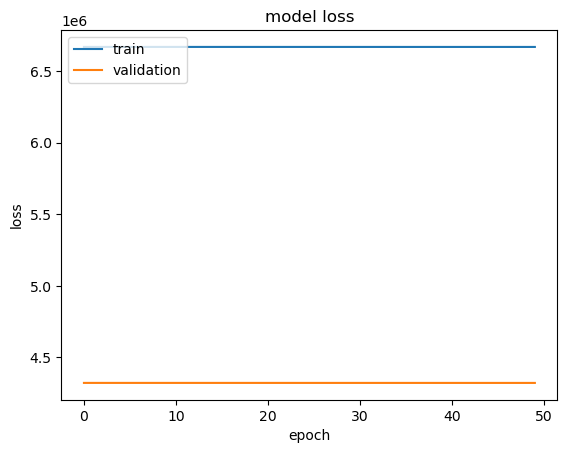

Use  model on test data...
1/1 [==============================] - 1s 1s/step
First predictions for x:  [[ 0.11210176 -0.04923096 -0.07634206]
 [ 0.1338795  -0.11828928  0.02020528]
 [ 0.13539061 -0.07613033 -0.0217196 ]
 [ 0.15749376 -0.16169806  0.16970375]
 [ 0.20841125  0.08247066  0.08221924]]
First predictions for y:  [[ 0.10885115 -0.10888974 -0.09551005]
 [ 0.30022472 -0.11760599  0.05698336]
 [ 0.22174461 -0.21638595 -0.05868706]
 [ 0.27983543 -0.26286772  0.28509045]
 [ 0.34457675 -0.01241947  0.13597506]]


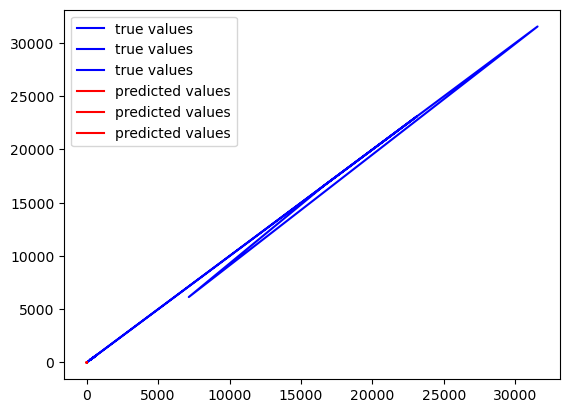

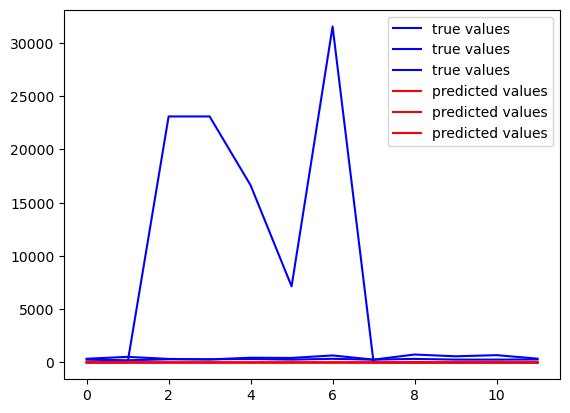

In [3]:
model = PredictionModelTrace(data)

In [40]:
import tensorflow as tf

segments = []
labels = []
split_indices, = np.where(data["reset"] == 1)
# add beginning and end to the split indices
split_indices = np.insert(split_indices, 0, 0)
split_indices = np.append(split_indices, len(data)-1)

l = max(np.diff(split_indices))

dataframe = data
for i in range(0,len(split_indices)-1):
    vel_x = dataframe['vel_x'].values[split_indices[i]: split_indices[i+1]]
    vel_y = dataframe['vel_y'].values[split_indices[i]: split_indices[i+1]]
    vel_z = dataframe['vel_z'].values[split_indices[i]: split_indices[i+1]]
    nav_x = dataframe['nav_ax'].values[split_indices[i]: split_indices[i+1]]
    nav_y = dataframe['nav_ay'].values[split_indices[i]: split_indices[i+1]]
    nav_z = dataframe['nav_az'].values[split_indices[i]: split_indices[i+1]]
    ax = dataframe['ax'].values[split_indices[i]: split_indices[i+1]]
    ay = dataframe['ay'].values[split_indices[i]: split_indices[i+1]]
    az = dataframe['az'].values[split_indices[i]: split_indices[i+1]]
    gx = dataframe['gx'].values[split_indices[i]: split_indices[i+1]]
    gy = dataframe['gy'].values[split_indices[i]: split_indices[i+1]]
    gz = dataframe['gz'].values[split_indices[i]: split_indices[i+1]]
    q0 = dataframe['q0'].values[split_indices[i]: split_indices[i+1]]
    q1 = dataframe['q1'].values[split_indices[i]: split_indices[i+1]]
    q2 = dataframe['q2'].values[split_indices[i]: split_indices[i+1]]
    q3 = dataframe['q3'].values[split_indices[i]: split_indices[i+1]]

    x = dataframe['x'].values[split_indices[i]: split_indices[i+1]].reshape(-1,1)
    y = dataframe['y'].values[split_indices[i]: split_indices[i+1]].reshape(-1,1)
    z = dataframe['z'].values[split_indices[i]: split_indices[i+1]].reshape(-1,1)

    features = np.transpose(np.hstack((vel_x, vel_y, vel_z, nav_x, nav_y, nav_z, ax, ay, az, gx, gy, gz, q0, q1, q2, q3))).flatten()
    
    positions = np.hstack((x,y,z))
    if i == 0:
        print(positions)
    positions = positions.flatten()
    if i == 0:
        print(positions)

    segments.append(features)
    labels.append(positions)

segments = tf.keras.preprocessing.sequence.pad_sequences(segments, padding="post", value = -1000, maxlen=l*16)
labels = tf.keras.preprocessing.sequence.pad_sequences(labels, padding="post", value = -1000, maxlen= l*3)

reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(len(split_indices)-1,-1, 16)
reshaped_labels = np.asarray(labels, dtype= np.float32).reshape(len(split_indices)-1,-1, 3)

print(reshaped_labels.shape)
print(reshaped_segments.shape)


[[ -125.           727.             0.        ]
 [ -125.           727.             0.        ]
 [ -125.           727.             0.        ]
 ...
 [  165.10208286   131.09215235 22709.28755394]
 [  165.10208286   131.29098308 21275.94664018]
 [  165.10208286   131.40510018 20991.        ]]
[ -125.           727.             0.         ...   165.10208286
   131.40510018 20991.        ]
(52, 2375, 3)
(52, 2375, 16)
